In [1]:
import os
import sys
from matplotlib import pyplot as plt
import random
import numpy as np
import pandas as pd
%matplotlib inline
plt.style.use("ggplot")

## Exercise 2.11

In [2]:
class BanditEnv(object):
    def __init__(self,qs):
        self.qs = qs.copy()
        self.reset()
    
    def reset(self):
        self.means = self.qs.copy()
        self.stds = [1 for i in self.qs]
        self.action_space = len(self.qs)
    
    def step(self,action):
        std,mean = self.stds[action],self.means[action]
        rand_raward = np.random.normal(mean,std)
        return rand_raward

In [3]:
class NonstationaryBanditEnv(BanditEnv):
    def step(self,action):
        std,mean = self.stds[action],self.means[action]
        rand_raward = np.random.normal(mean,std)
        for one_action in range(self.action_space):
            self.means[one_action] += np.random.normal(0,0.01)
        return rand_raward

In [4]:
class SampleAverageSolver(object):
    def __init__(self,env,e=0.1):
        self.env = env
        self.action_space = env.action_space
        self.e = e
        
    def back(self,selected_action,reward):
        self.action_steps[selected_action] += 1
        if self.Qs[selected_action] == np.inf:
            self.Qs[selected_action] = 0
        self.Qs[selected_action] += \
            (1.0 / self.action_steps[selected_action]) * (reward - self.Qs[selected_action])
        
    def solve(self,steps):
        self.Qs = [np.inf for i in range(self.action_space)]
        self.action_steps = [0 for i in range(self.action_space)]
        
        rewards = []
        actions = []
        correct = []
        for i in range(steps):
            rand_action = np.random.randint(0,self.action_space)
            # explore
            if random.random() < self.e:
                selected_action = rand_action
            # exploit
            else:
                selected_action = np.argmax(self.Qs)
            
            reward = self.env.step(selected_action)
            rewards.append(reward)
            #actions.append(selected_action)
            correct.append(selected_action == np.argmax(self.env.means))
            self.back(selected_action,reward)
            
        return rewards,self.Qs,correct
    
class ConstStepsizeSolver(SampleAverageSolver):
    def back(self,selected_action,reward):
        self.action_steps[selected_action] += 1
        if self.Qs[selected_action] == np.inf:
            self.Qs[selected_action] = 0
        self.Qs[selected_action] += \
            0.1 * (reward - self.Qs[selected_action])
        

In [5]:
env = NonstationaryBanditEnv(np.zeros(10))
const_stepsize_solver = ConstStepsizeSolver(env)

In [6]:
def graph_runner(solver,solve_steps,average_steps):
    
    sums = np.zeros(solve_steps)
    corrects = np.zeros(solve_steps)
    
    solver.env.reset()
    rewards,Qs,correct_action = solver.solve(solve_steps)
    rewards = np.asarray(rewards)
    correct_action = np.asarray(correct_action)
    
    sums += rewards
    corrects += np.asarray(correct_action,np.float)
    
    return np.average(rewards[-average_steps:]),np.average(corrects[-average_steps:])

In [7]:
reward_dic = {}
acc_dic = {}

xs = []
for i in range(10):
    random.seed(1233)
    np.random.seed(1233)
    e = (1.0 / 1024) * (2 ** i)
    xs.append(e)
    env.reset()
    const_stepsize_solver = ConstStepsizeSolver(env,e=e)
    avg_reward,acc = graph_runner(const_stepsize_solver,200000,100000)
    
    reward_dic.setdefault("ConstStepsizeSolver",[])
    reward_dic["ConstStepsizeSolver"].append(avg_reward)
    
    acc_dic.setdefault("ConstStepsizeSolver",[])
    acc_dic["ConstStepsizeSolver"].append(acc)

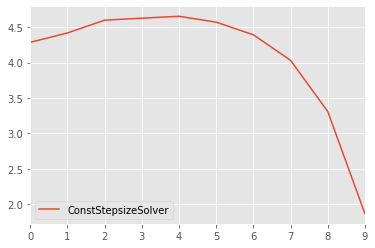

In [8]:
pd.DataFrame(reward_dic).plot()

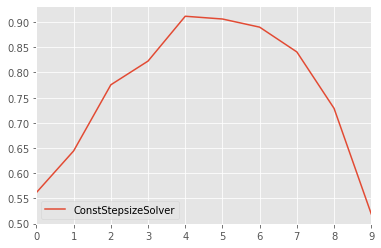

In [9]:
pd.DataFrame(acc_dic).plot()